# Loading Seismic Data from OpendTect

I have struggled for a long time trying to load in SEG-Y data into Python, making attempts with methods such as [ObsPy](http://docs.obspy.org/gallery.html) and [SEGPy](https://pypi.python.org/pypi/segpy), only to have them work with simple 2D data and perfectly formatted 3D headers.  After much trial and error I have settled on a method that works consistently everytime - using the free interpretive software [OpendTect](http://www.opendtect.org/) to load the SEG-Y volume, then export it as a simple ASCII file.  Granted this is a work around, but a work around that is reliable and causes less headaches.

Below is a pseudo guide that will attempt to walk you through the process of loading the exported ASCII file from OpendTect (I'll leave it up to you on how to import the survey and then export it; their help manual is very good) and some very brief examples of displaying the data.  More 'in depth' examples of data visualization and manipulation will be reviewed in subsequent notebooks.

## The Data Set
All work will be done using the Penobscot 3D data set found [here](https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND) which is part of the Open Seismic Repository.  The survey is located off the coast of Nova Scotia and is approximately 85 $km^2$.  Parameters are 680 inlines, 481 crosslines, bin size of 12x25 (in/xl), and a total samples range of 6000 ms sampled at 4 ms.  More detailed information, including geologic setting, can be found on the website.


## Loading the File
The exported ASCII file from OpendTect is a 'flat' file which contains, **if selected**, inline and crossline information associated for each trace.  This means that we will need to first read in the data, then map the traces into the proper survey geometry.

Lets load in the file and take a look:

In [5]:
#first we need to load in the usual suspects
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [6]:
#load in the ascii file
ascii_seis = np.loadtxt('PEN3D_Test.txt')
print ('The shape of the imported file is: ' , ascii_seis.shape)

The shape of the imported file is:  (288678, 503)


As we can see, the imported survey is a flat file with 288678 traces, each with 503 samples associated with it.  Note that there are only 503 sample points per trace instead of 1500 (6000/4) because I have trimmed the file for the sake of computational efficiency.  

The 503 samples also requires some further explanation.  Technically, I only exported 2004 ms of data (or 501 samples) not 2012.  The extra two samples on each trace are the inline/crossline information which we will use to help us map the data into the proper locations.

Before we create our 3D array representing our survey volume, lets take a look at a trace to make sure everything is looking right and get a bit more of an intuitive feel for the inline/crossline information.

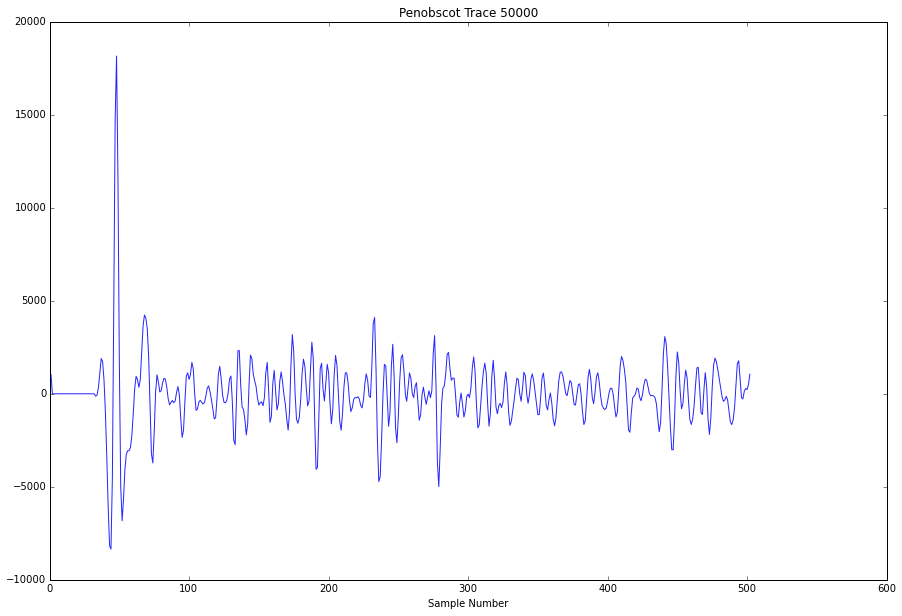

In [7]:
#plot a random trace to investigate data quality 
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(ascii_seis[50000], alpha=0.85)
ax.set_title('Penobscot Trace 50000')
ax.set_xlabel('Sample Number')
plt.show()

Data looks good!  Lets now look at those first two samples points to find out what inline/xline location trace 50,000 falls at.  The inline location comes first, followed by the crossline.

In [8]:
print('The inline location of trace 50,000 is: ', ascii_seis[50000,0])
print('The crossline location of trace 50,000 is: ', ascii_seis[50000,1])

The inline location of trace 50,000 is:  1104.0
The crossline location of trace 50,000 is:  1056.0


There we go, trace 50,000 falls at inline 1104 and crossline 1056.

Now that we know the data looks good and that we can easily locate the location of each trace, lets finally turn the ASCII file into a 3D Numpy array so we can start to look at some inlines/crosslines and time slices.

#### Below is a function called 'create_data' that can be used to take any OpendTect exported ASCII file and map it into the survey geometry

Essentially, the function reads the ASCII file, finds the survey geometry, creates an array of that shape filled with zeros, subsequently replaces the zeros with NaNs (for attribute analysis reasons), then uses a loop to place each trace in the array at the right location.

In [9]:
def create_data(data):
    '''Makes a simple SEGY ascii file exported from OpendTect and maps it into a 3D array for manipulation.  
    Must export the file with in/xl information!'''
    
    #Inlines are stored in the first time sample location (i.e index 0)
    #Crosslines are stored in the second time sample location (i.e index 1)
    inmax,inmin = np.max(data[:,0]) , np.min(data[:,0])#find the max/min inline
    xlmax,xlmin = np.max(data[:,1]) , np.min(data[:,1])#find crossline max/min
    samp = len(data[1,:])#find the amount of time samples in data
    time = samp - 2.0 #remove the in/xl values from the time values
    
    il,xl = (inmax-inmin) , (xlmax-xlmin) #find in/xl range
    
    print('The inline min and max are: ', inmin,inmax)
    print('The crossline min and max are: ', xlmin,xlmax)
    print('The number of inlines is: ', il)
    print('The number of crosslines is: ', xl)
    print('The number of time samples are: ', time)
    
    
    mapped_data = np.zeros([il,xl,time])
    print('The shape of the mapped data empty matrix is :', mapped_data.shape)
    np.place(mapped_data, mapped_data==0.0, np.nan)
    
    for i in range(len(data)):
        inl = data[i,0] - inmax
        xln = data[i,1] - xlmax
        mapped_data[inl,xln] = data[i,2:]
        
    return mapped_data

### Using the Function:

With the 'create_data' function defined, lets load in the ASCII file and start looking at the data:

In [10]:
seismic = create_data(ascii_seis)
print('The shape of the mapped data is: ', seismic.shape)

/Users/IanDeniset/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/IanDeniset/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The inline min and max are:  1000.0 1600.0
The crossline min and max are:  1000.0 1480.0
The number of inlines is:  600.0
The number of crosslines is:  480.0
The number of time samples are:  501.0
The shape of the mapped data empty matrix is : (600, 480, 501)
The shape of the mapped data is:  (600, 480, 501)


Perfect!  The geometry looks right, as do the amount of time samples.  Lets plot some times alices and inline/crosslines.

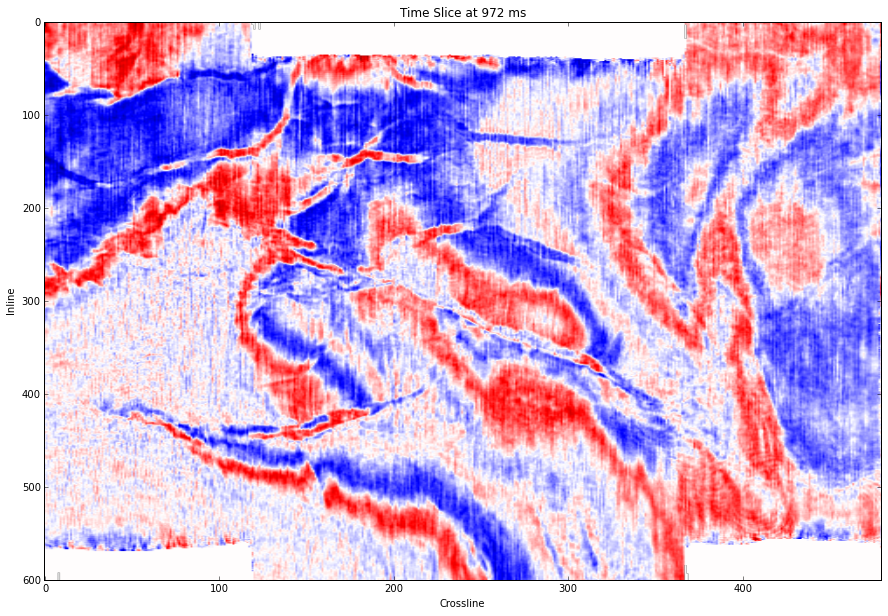

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(seismic[:,::-1,243], aspect='auto', cmap='seismic', clim=(-10000,10000))
ax.set_title('Time Slice at 972 ms')
ax.set_ylabel('Inline')
ax.set_xlabel('Crossline')
plt.show()

The slice looks good, geophysics is so cool.  The only complaint is that the slice looks a little 'washed out'.  Lets plot a histogram of the slice and see if we can tighten up the limits a bit.

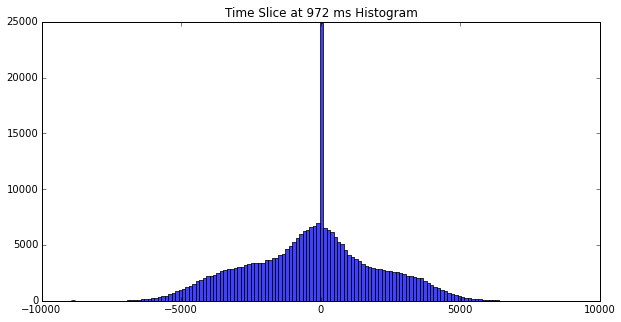

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(seismic[:,::-1,243][~np.isnan(seismic[:,::-1,243])].ravel(), bins=150, alpha=0.75)
ax.set_title('Time Slice at 972 ms Histogram')
plt.show()

Based on the histogram, I think we can tighten up the limits to $\pm$5000 and re-plot.  Before we do that though, lets plots up an inline and crossline as well and mark their locations on the time slice.

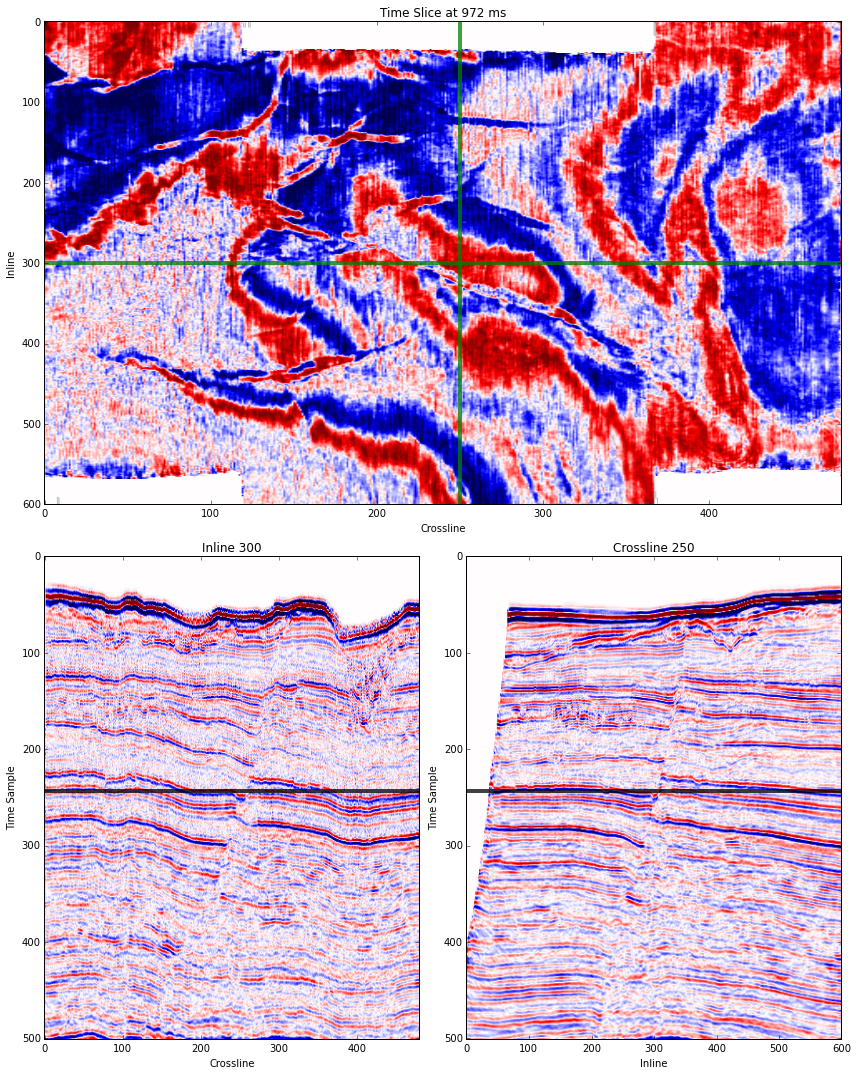

In [13]:
fig = plt.figure(figsize=(12,15))

ax1 = plt.subplot2grid((2,2),(0,0), colspan=2)
ax1.imshow(seismic[:,::-1,243], aspect='auto', cmap='seismic', clim=(-5000,5000))
ax1.axhline(y=300, linewidth=4, color = 'green', alpha=0.75)
ax1.axvline(x=250, linewidth=4, color = 'green', alpha=0.75)
ax1.set_title('Time Slice at 972 ms')
ax1.set_ylabel('Inline')
ax1.set_xlabel('Crossline')

ax2 = plt.subplot2grid((2,2),(1,0), colspan=1)
ax2.imshow(seismic[300,:,:].T, aspect='auto', cmap='seismic', clim=(-8000,8000))
ax2.axhline(y=243, linewidth=4, color = 'k', alpha=0.75)
ax2.set_title('Inline 300')
ax2.set_ylabel('Time Sample')
ax2.set_xlabel('Crossline')

ax3 = plt.subplot2grid((2,2),(1,1), colspan=1)
ax3.imshow(seismic[:,250,:].T, aspect='auto', cmap='seismic', clim=(-8000,8000))
ax3.axhline(y=243, linewidth=4, color = 'k', alpha=0.75)
ax3.set_title('Crossline 250')
ax3.set_ylabel('Time Sample')
ax3.set_xlabel('Inline')

plt.tight_layout()
plt.show()

And there we go, a nice timeslice/inline/crossline view of the survey!

With the ability to load seismic data into Python, many possibilities of data analysis and visualization open up.  Next will be turning these static displays into interactive ones to allow for more efficient data exploration.  After that I think some corendering is in order!